# Transfer learning week. 
## pytorch 

In [1]:
import math, seaborn, os, sys, posixpath, pathlib 
from matplotlib import pyplot as plt

import pprint 
#@typedispatch
#@delegate


In [2]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !wget 'https://download.pytorch.org/tutorial/hymenoptera_data.zip' -o ./hymenoptera_data.zip
# https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

def show_dir( obj ): return [item for item in dir( obj ) if not item.startswith('_') ]

data_path = "./data/hymenoptera_data"
os.listdir( os.path.join( data_path,'train','bees') )[0:5]


['473618094_8ffdcab215.jpg',
 '174142798_e5ad6d76e0.jpg',
 '873076652_eb098dab2d.jpg',
 '2822388965_f6dca2a275.jpg',
 '92663402_37f379e57a.jpg']

In [3]:
data_dir = 'data/hymenoptera_data'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 
# each is a dataset (train and val), is a class that abstracts an iterable used during training. 
# dataloaders call the __get__item__ method of the dataset, which returns one example and its label 
# a dataset needs to implement as a minimum the __get_item__ and __geT_length__ methods 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x) ,data_transforms[x]) for x in ['train', 'val']}
# in herits from 
# torchvision.datasets.folder.ImageFolder,
# torchvision.datasets.folder.DatasetFolder,
# torchvision.datasets.vision.VisionDataset,
# torch.utils.data.dataset.Dataset,

# a data loader iterates over a dataset and retieves batches. 
# each loader has a reference to its dataset
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
# same id 
# id(data_loaders['train'].dataset), id( image_datasets['train'])

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#note that the class names are taken from the folder names. 
class_names = image_datasets['train'].classes
print( class_names, dataset_sizes )

['ants', 'bees'] {'train': 244, 'val': 153}


/home/vscode/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


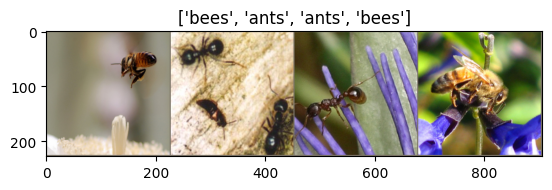

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data, images + labels 
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
from torchvision import models
dir(models)[0:5]

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights']

In [6]:
# https://pytorch.org/vision/stable/models.html

#!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# ther labels for imagenet1K 
with open('imagenet_classes.txt') as f: 
  classes = [line.strip() for line in f.readlines()]

# model with pre-trained weights and all the layers. 
# Note the last layer is the classification layer. Thats the one to fine-tune in the 
# general case.  
from torchvision.models import resnet18, ResNet18_Weights
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)#'IMAGENET1K_V1')
pprint.pprint(model_ft)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

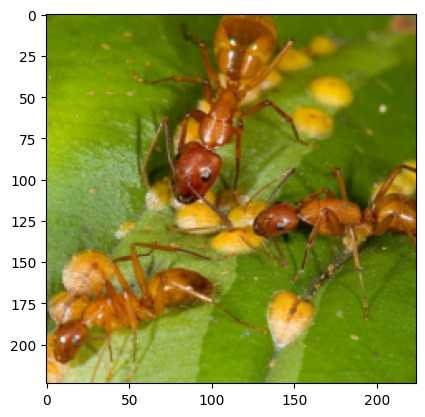

0


In [9]:
#get one image from  the new training set 
image1 = image_datasets['val'][11][0] #0 is the image, 1 is he label 
label1 = image_datasets['val'][11][1] #0 is the image, 1 is he label 

imshow(image1) # seems to be an ant 
print(label1)  # ants = 0 


In [10]:
batch_t = torch.unsqueeze(image1, 0) 
model_ft.eval() 
out = model_ft(batch_t)

_, max_prob_index = torch.max( out, 1 ) # 1 if for dim out is (images, labels )
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print('class ', classes[max_prob_index[0]], 'prob ', percentage[max_prob_index[0]].item())

# how do I predict the class or a number iof images?
# images = np.array( [0.25*np.ones((3,224,224), dtype=np.float32),0.25*np.ones((3,224,224), dtype=np.float32)])
# t = torch.from_numpy( images )
# model_ft( t )



class  ant prob  98.29681396484375


In [66]:
# lets see first whats the baseline. Whats the accuracy for the validation set. 

baseline_data_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=4, num_workers=1)

predictions = [] 
true_labels = [] 
model_ft.eval() 
for b,c in baseline_data_loader:
    
    out = model_ft( b )
    
    _, imagenet_indices = torch.max( out, 1 )
    imagenet_labels = [  classes[index] for index in imagenet_indices ] 
    predictions = predictions + imagenet_labels 
    true_labels = true_labels + ['ant' if x ==0 else 'bee' for x  in c.detach().numpy().tolist() ]
  



,prediction,true,score,error
0,fountain,ant,0,1
1,ant,ant,1,0
2,mantis,ant,0,1
3,ant,ant,1,0
4,ant,ant,1,0
...,...,...,...,...
148,bee,bee,1,0
149,monarch,bee,0,1
150,ant,bee,0,1
151,bee,bee,1,0


(65, 1, 49, 1)

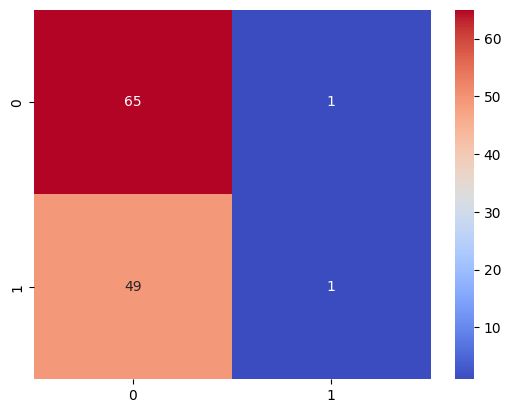

In [67]:
import pandas as pd 
df = pd.DataFrame( {'prediction':predictions, 'true':true_labels} )
df['score'] = ( df['prediction'] == df['true']).astype( int )
df['error'] = (1 - df['score'])**2
display( df[ df['true'].isin( ['bee','ant'] )] )
        
true_ants = df[df['true']=='ant']['score'].sum()
false_ants = df[df['prediction']=='ant']['error'].sum()

true_bees = df[df['true']=='bee']['score'].sum()
false_bees = df[df['prediction']=='bee']['error'].sum()

import seaborn as sns
sns.heatmap( [[true_bees,false_bees],
              [true_ants,false_ants]], annot=True, cmap='coolwarm')

true_bees,false_bees, true_ants, false_ants

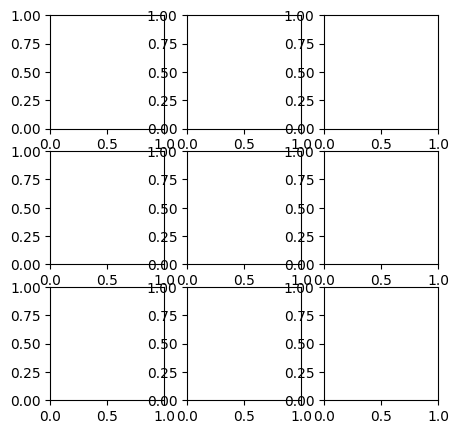

In [34]:


def get_grid(
    n:int, # Number of axes in the returned grid
    nrows:int=None, # Number of rows in the returned grid, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns in the returned grid, defaulting to `ceil(n/rows)` 
    figsize:tuple=None, # Width, height in inches of the returned figure
    title:str=None, # If passed, title set to the figure
    #return_fig:bool=False, # Whether to return the figure created by `subplots`
    **kwargs 
    ):
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.ceil(n/nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    
    fig,axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) # if return_fig else axs

fig,ax =  get_grid( 9, figsize = (5,5) )

In [20]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )